In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta

import pollux as plx
from pollux.models.transforms import LinearTransform

jax.config.update("jax_enable_x64", True)
%matplotlib inline

/Users/aprice-whelan/projects/pollux/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, some tests of the transforms:

In [2]:
trans = LinearTransform(8)
# trans = QuadraticTransform(8)

In [3]:
latent_size = 16

rng = np.random.default_rng(seed=42)
latents = rng.uniform(size=(128, latent_size))
A = rng.uniform(size=(8, latent_size))
assert trans.apply(latents, A=A).shape == (128, 8)
assert trans.get_priors(latent_size)["A"].batch_shape == (8, latent_size)

---

In [4]:
L = 2  # number of labels
T = 8  # number of latents
F = 128  # number of flux values
N = 2048  # number of stars

rng = np.random.default_rng(seed=8675209)

# alpha = rng.normal(0., label_scales, size=(M, K))
alpha = np.zeros((L, T))
alpha[0, 0] = 1.0
alpha[1, 1] = 1.0

beta = rng.normal(scale=0.1, size=(F, T))
beta[:, 0] = beta[:, 0] + 4 * np.exp(
    -0.5 * (np.arange(beta.shape[0]) - beta.shape[0] / 2) ** 2 / 5**2
)
beta[:, 1] = beta[:, 1] + 2 * np.exp(
    -0.5 * (np.arange(beta.shape[0]) - beta.shape[0] / 4) ** 2 / 3**2
)


def make_data(N, rng):
    # label_scales = 10 ** rng.uniform(-2, 2, size=(M, 1))
    label_scales = jnp.ones((L, 1))

    zeta = rng.normal(size=(N, T))

    labels = (alpha @ zeta.T).T
    fluxs = (beta @ zeta.T).T

    label_err = rng.uniform(0.01, 0.1, size=labels.shape) * label_scales.T
    flux_err = rng.uniform(0.01, 0.1, size=fluxs.shape)

    obs = {
        "label": rng.normal(labels, label_err),
        "label_err": label_err,
        "flux": rng.normal(fluxs, flux_err),
        "flux_err": flux_err,
    }
    truth = {
        "label": labels,
        "flux": fluxs,
        "alpha": alpha,
        "beta": beta,
        "zeta": zeta,
    }

    return obs, truth


data, data_true = make_data(2 * N, rng=rng)

In [5]:
from pollux.data import NormalizePreprocessor

all_data = plx.data.PolluxData(
    flux=plx.data.OutputData(
        data["flux"], err=data["flux_err"], preprocessor=NormalizePreprocessor
    ),
    label=plx.data.OutputData(
        data["label"], err=data["label_err"], preprocessor=NormalizePreprocessor
    ),
    # Note: use partial(NormalizePreprocessor, scale=1.0) to set a custom scale
)

train_data = all_data[:N]
test_data = all_data[N:]

assert train_data["flux"].preprocessor == test_data["flux"].preprocessor

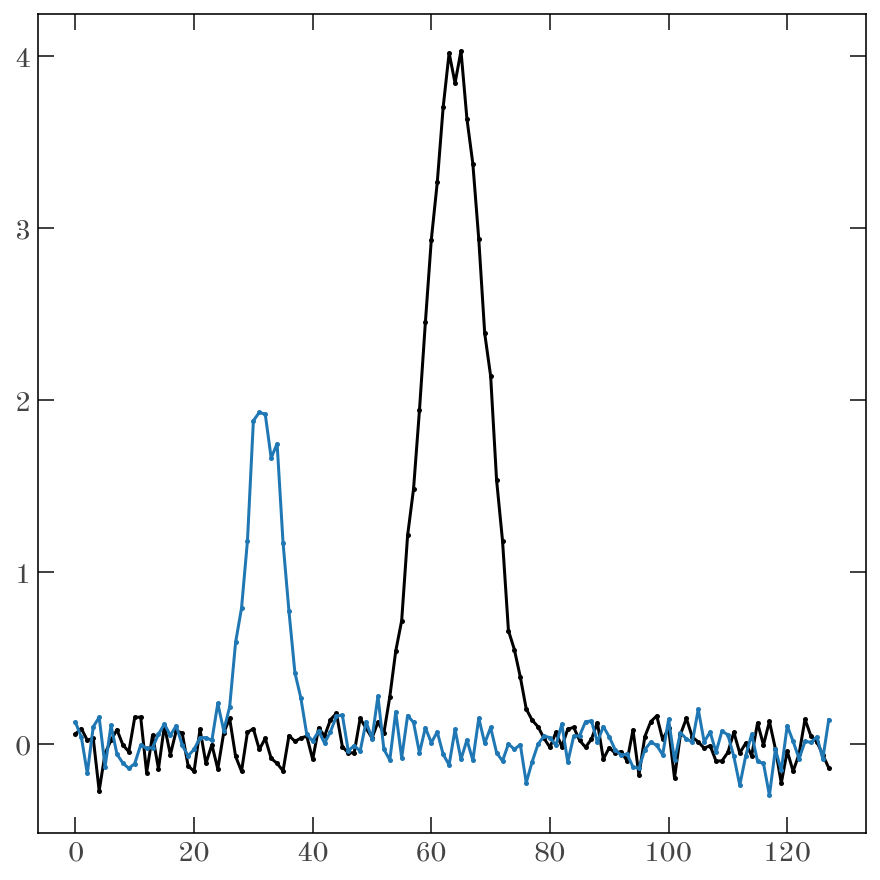

In [6]:
plt.plot(beta[:, 0])
plt.plot(beta[:, 1])

In [47]:
model = plx.LuxModel(latent_size=T * 8)
model.register_output("label", transform=LinearTransform(output_size=L))
model.register_output("flux", transform=LinearTransform(output_size=F))

Test evaluating the model:

In [48]:
z = jax.random.normal(jax.random.PRNGKey(0), shape=(N, model.latent_size))
params = {
    "label": {
        "A": jax.random.normal(jax.random.PRNGKey(1), shape=(L, model.latent_size)),
        # "b": jnp.zeros((L,)),
    },
    "flux": {
        "A": jax.random.normal(jax.random.PRNGKey(2), shape=(F, model.latent_size)),
        # "b": jnp.zeros((F,)),
    },
}
outputs = model.predict_outputs(z, params)
outputs["label"].shape, outputs["flux"].shape

((2048, 2), (2048, 128))

In [49]:
# _data = {"labels": data["label"], "flux": data["flux"]}
# _err = {"labels": data["label_err"], "flux": data["flux_err"]}
# paton_model.default_numpyro_model(_data, _err)

# opt = optimx.optimize(
#     paton_model.default_numpyro_model,
#     optimizer=numpyro.optim.Adam(1e-3),
#     num_steps=1_000,
# )
# res = opt(jax.random.PRNGKey(101), _data, _err)

In [50]:
rng_key = jax.random.PRNGKey(112358)

svi_key, sample_key = jax.random.split(rng_key, 2)

optimizer = numpyro.optim.Adam(1e-3)
guide = AutoDelta(model.default_numpyro_model)
svi = SVI(model.default_numpyro_model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(svi_key, 10_000, train_data)
unpacked_MAP_params = guide.sample_posterior(sample_key, svi_results.params)
MAP_params = model.unpack_numpyro_params(unpacked_MAP_params)

100%|██████████| 10000/10000 [00:12<00:00, 773.81it/s, init loss: 305727356.5725, avg. loss [9501-10000]: -116353.9044]


In [51]:
unproc_MAP_train_values = model.predict_outputs(MAP_params["latents"], MAP_params)

In [52]:
MAP_train_values = {}
for k, values in unproc_MAP_train_values.items():
    MAP_train_values[k] = all_data[k].preprocessor.inverse_transform(values)

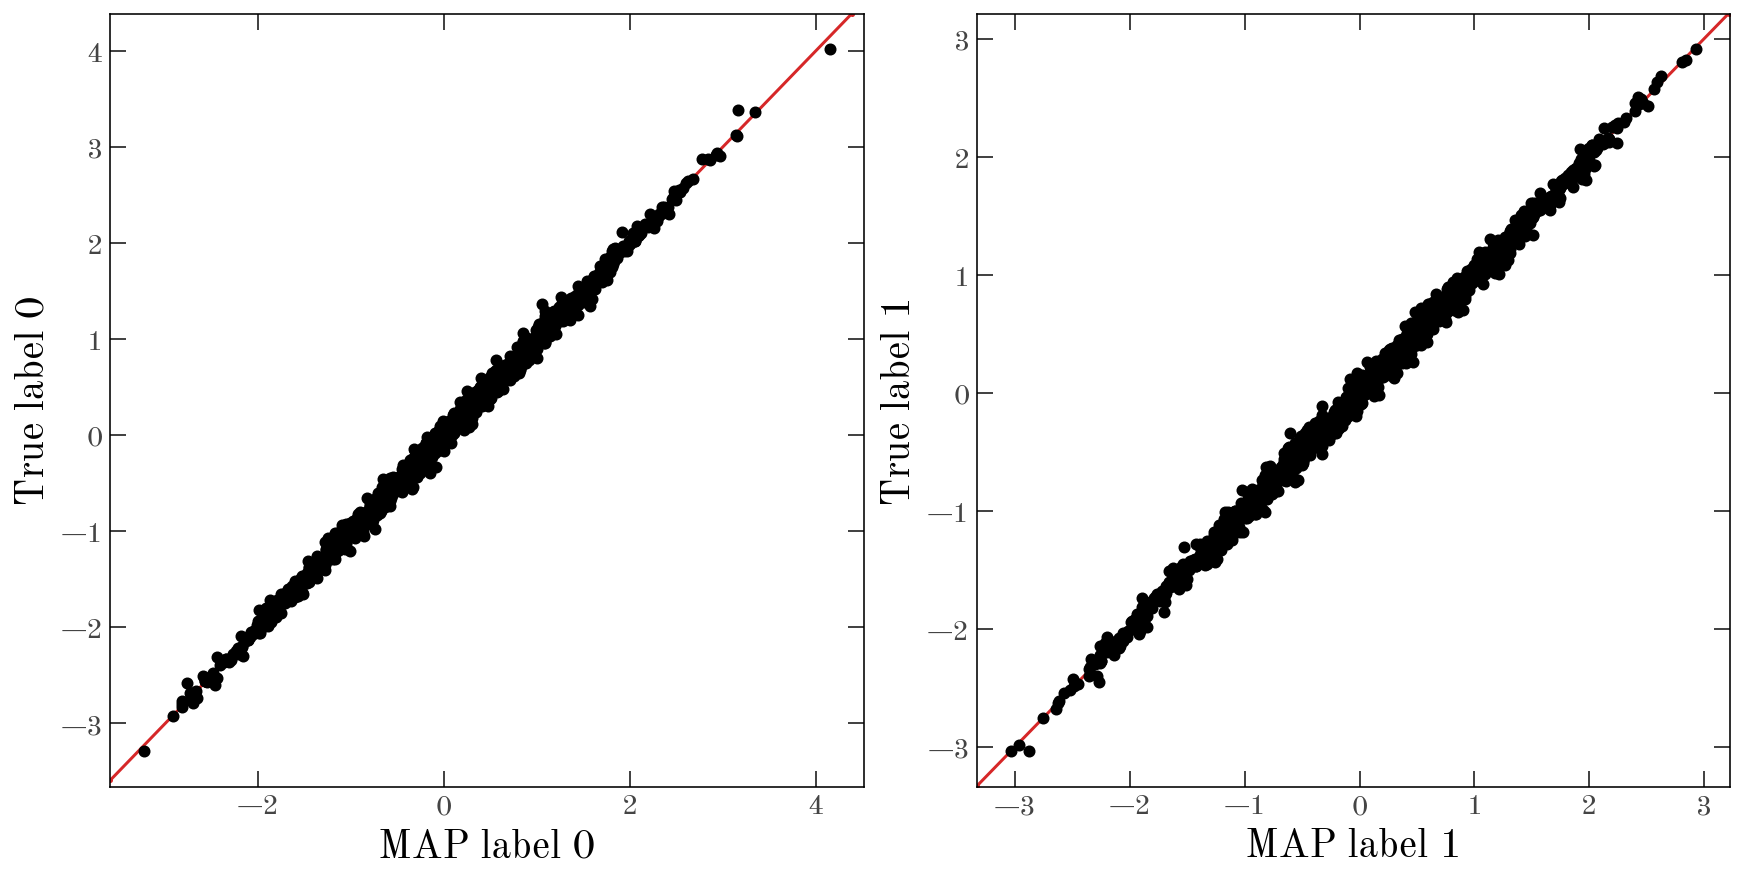

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i in range(MAP_train_values["label"].shape[1]):
    axes[i].scatter(MAP_train_values["label"][:, i], train_data["label"].data[:, i])
    axes[i].set_xlabel(f"MAP label {i}")
    axes[i].set_ylabel(f"True label {i}")
    axes[i].axline([0, 0], slope=1, color="tab:red", zorder=-100)

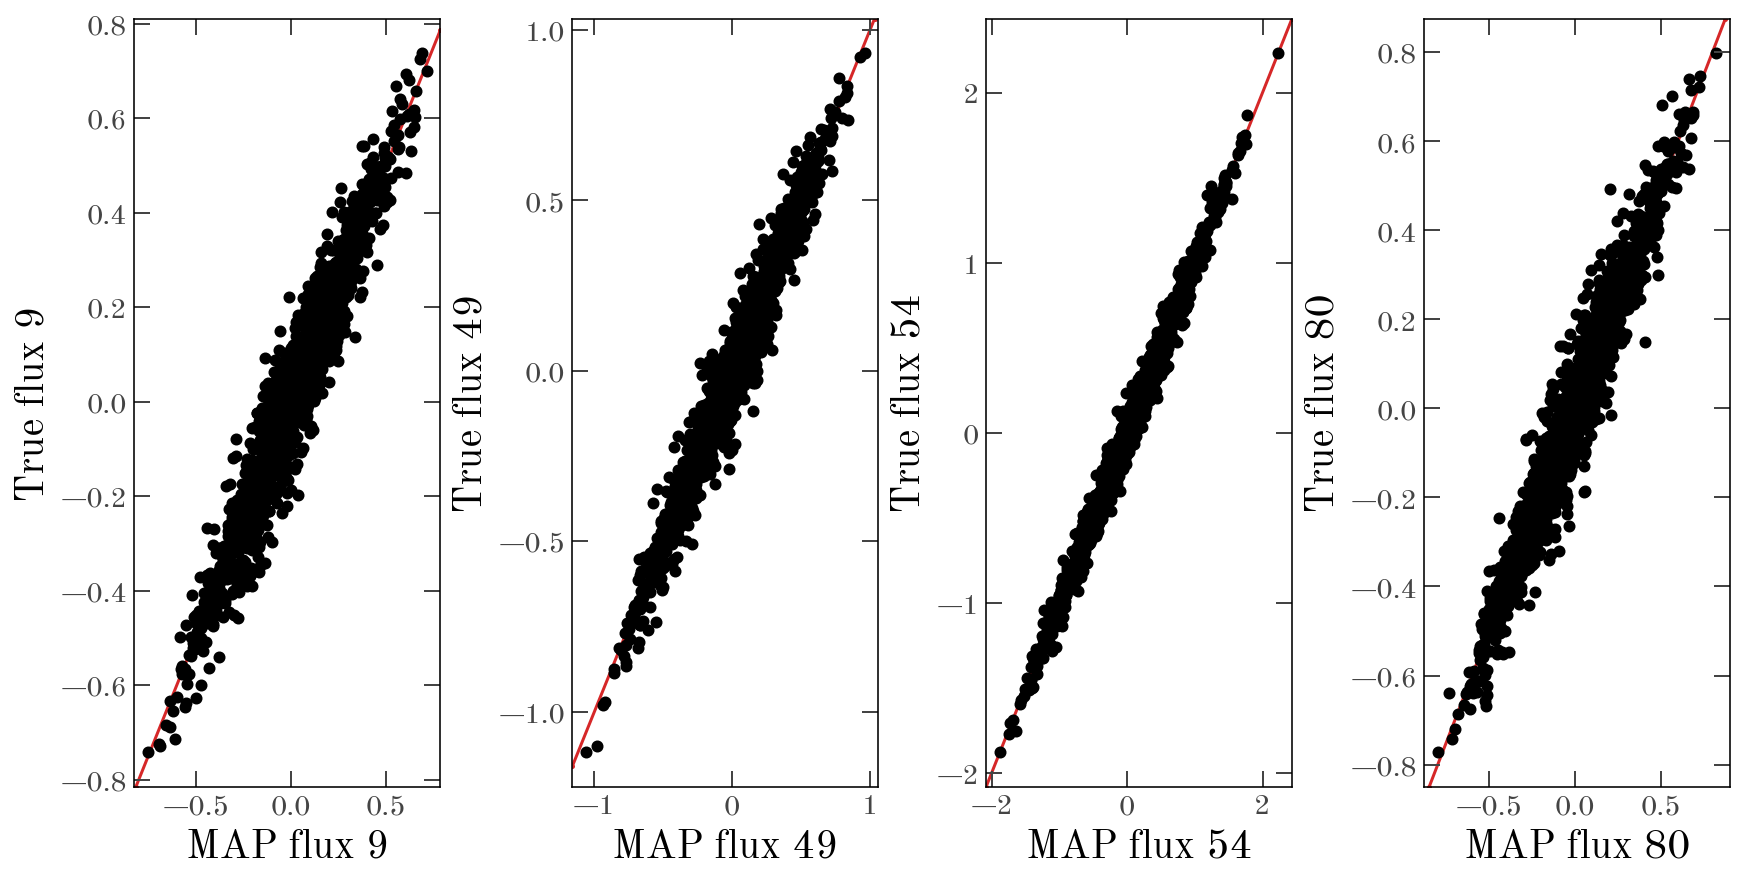

In [54]:
rng = np.random.default_rng(seed=333444)
idx = np.sort(rng.choice(F, size=4, replace=False))
fig, axes = plt.subplots(1, len(idx), figsize=(12, 6))
for i, j in enumerate(idx):
    axes[i].scatter(MAP_train_values["flux"][:, j], train_data["flux"].data[:, j])
    axes[i].set_xlabel(f"MAP flux {j}")
    axes[i].set_ylabel(f"True flux {j}")
    axes[i].axline([0, 0], slope=1, color="tab:red", zorder=-100)

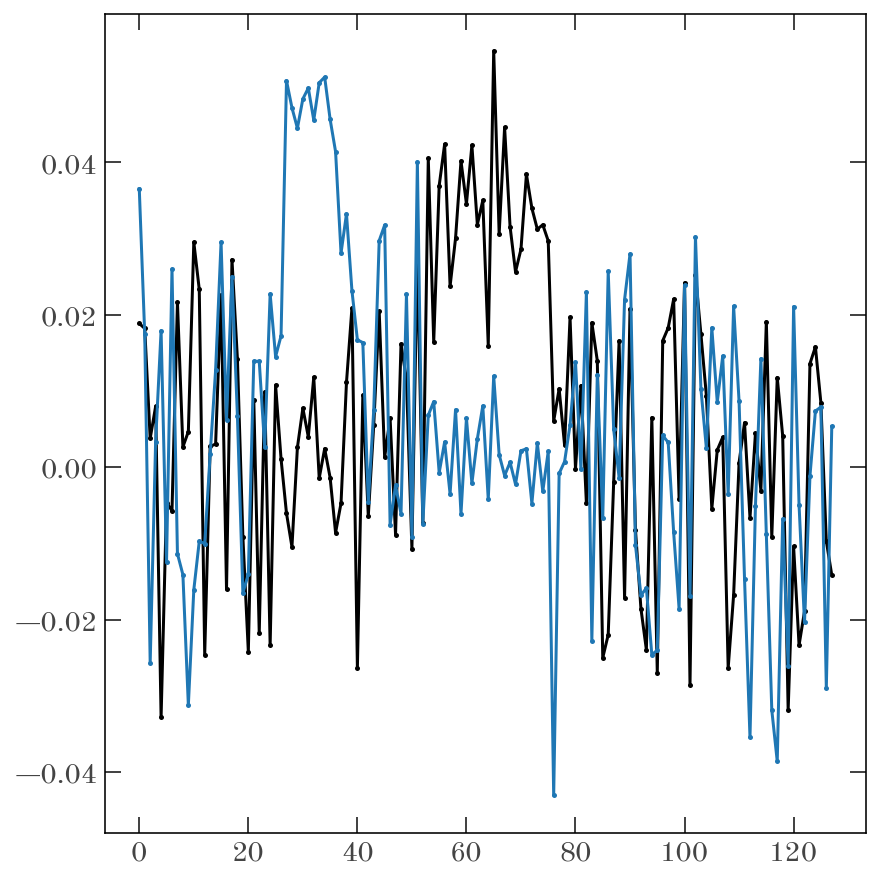

In [55]:
A = MAP_params["label"]["A"].T
B = MAP_params["flux"]["A"].T

deriv1 = np.linalg.pinv(np.linalg.pinv(B) @ A)
deriv2 = np.linalg.pinv(np.linalg.pinv(A) @ B)

# plt.plot(deriv1.T)
plt.plot(deriv2)

## Optimize for latents for test set

labels -> latents -> flux

and

flux -> latents -> labels

In [56]:
rng_key = jax.random.PRNGKey(112358)

svi_key, sample_key = jax.random.split(rng_key, 2)

fixed_params = unpacked_MAP_params.copy()
fixed_params.pop("latents")

fixed_model = lambda data: model.default_numpyro_model(  # noqa: E731
    data, fixed_params=fixed_params
)

optimizer = numpyro.optim.Adam(1e-3)
svi = SVI(
    model=fixed_model,
    guide=AutoDelta(fixed_model),
    optim=optimizer,
    loss=Trace_ELBO(),
)
svi_results = svi.run(svi_key, 10_000, test_data)
# test_unpacked_MAP_params = guide.sample_posterior(sample_key, svi_results.params)
# test_MAP_params = paton_model.unpack_numpyro_params(test_unpacked_MAP_params)
test_latent_z = svi_results.params["latents_auto_loc"]

100%|██████████| 10000/10000 [00:11<00:00, 865.39it/s, init loss: 281716968.7514, avg. loss [9501-10000]: -107714.7369]


In [57]:
unproc_test_predict = model.predict_outputs(test_latent_z, MAP_params)
test_predict = {}
for k, values in unproc_test_predict.items():
    test_predict[k] = all_data[k].preprocessor.inverse_transform(values)

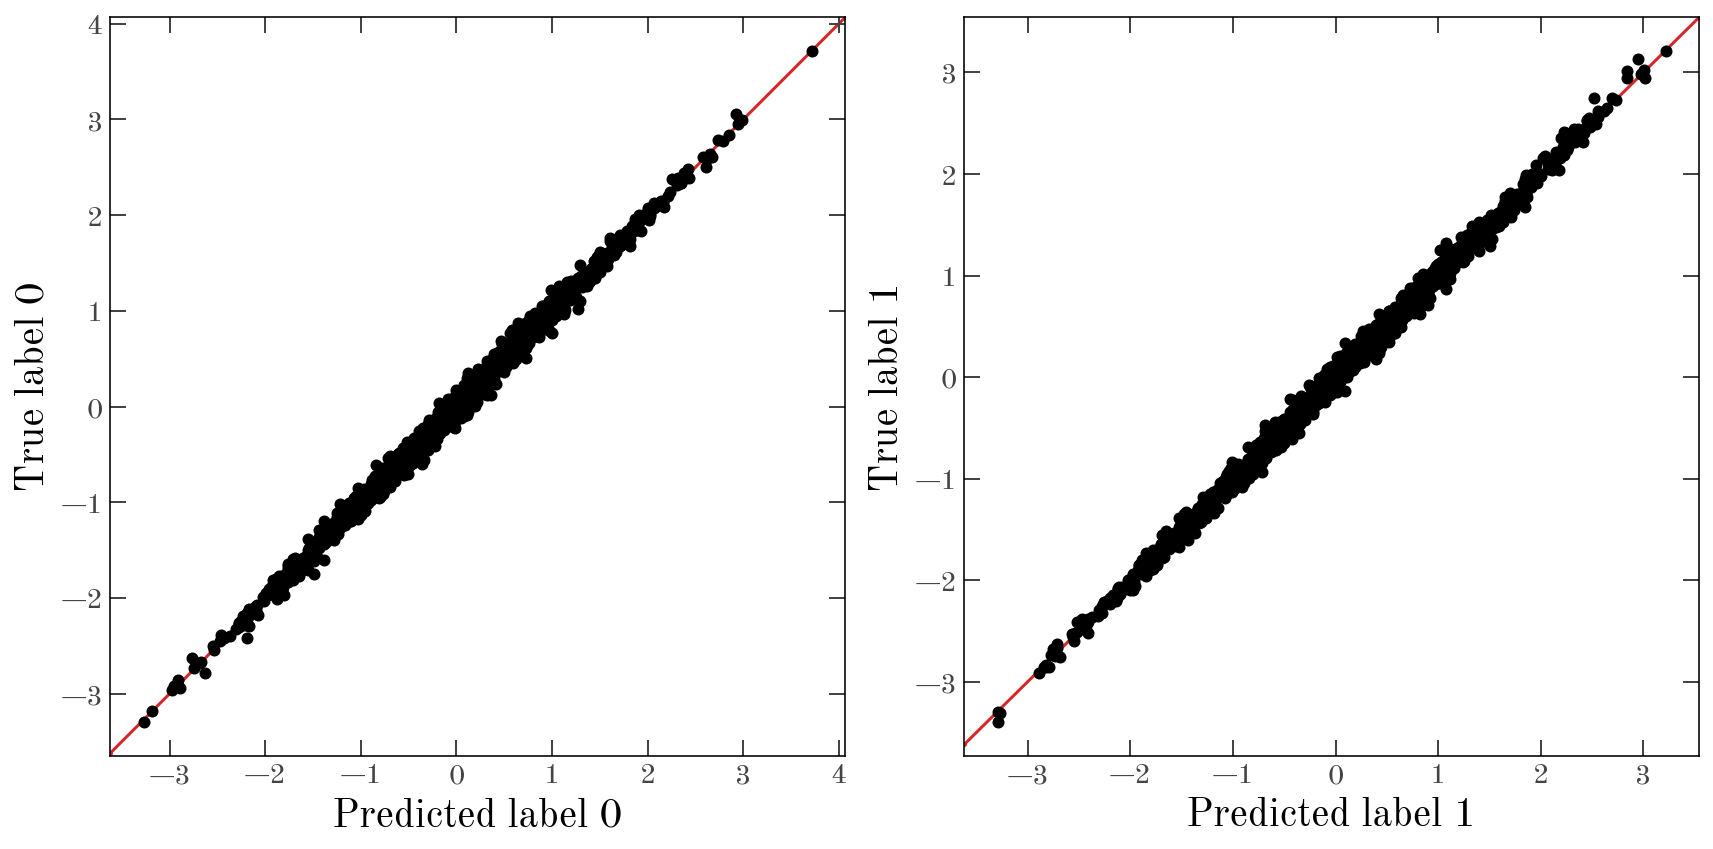

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), layout="tight")
for i, ax in enumerate(axes):
    ax.scatter(test_predict["label"][:, i], test_data["label"].data[:, i])
    ax.set_xlabel(f"Predicted label {i}")
    ax.set_ylabel(f"True label {i}")
    ax.axline([0, 0], slope=1, color="tab:red", zorder=-100)

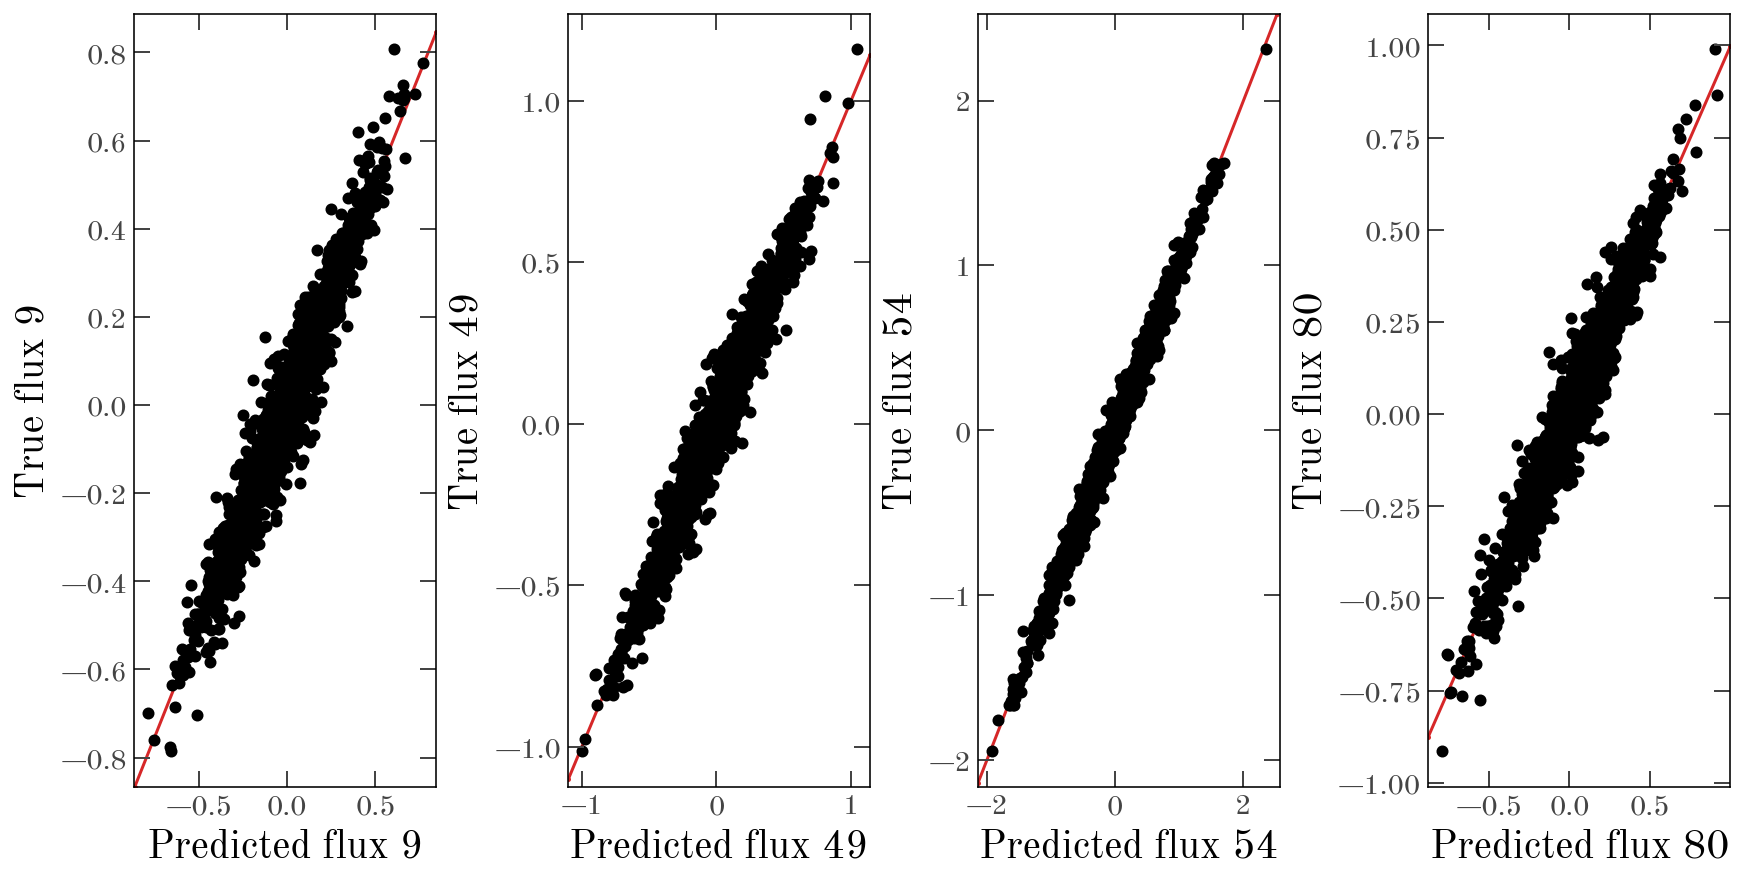

In [59]:
rng = np.random.default_rng(seed=333444)
idx = np.sort(rng.choice(F, size=4, replace=False))
fig, axes = plt.subplots(1, len(idx), figsize=(12, 6))
for i, j in enumerate(idx):
    axes[i].scatter(test_predict["flux"][:, j], test_data["flux"].data[:, j])
    axes[i].set_xlabel(f"Predicted flux {j}")
    axes[i].set_ylabel(f"True flux {j}")
    axes[i].axline([0, 0], slope=1, color="tab:red", zorder=-100)

In [46]:
np.std(test_predict["label"] - data_true["label"][N:], axis=0)

Array([0.01056396, 0.01617711], dtype=float64)

In [62]:
np.mean(np.std(test_predict["flux"] - data_true["flux"][N:], axis=0))

Array(0.02035473, dtype=float64)